# src_4

This time I'm looking to create a [Kármán vortex street](https://en.wikipedia.org/wiki/K%C3%A1rm%C3%A1n_vortex_street). The aim is to maintain the flow speed at about $\mathcal{O}(10^{-3})~\mathrm{mm}/\mathrm{s}$, but increase significantly the Reynolds number.

My approach to do this is 
$$
\begin{gather}
\rho \to \rho' = A \rho\\
\nu \to \nu' = \frac{\nu}{A}
\end{gather}
$$
since $\mathrm{Re} = u L / \nu$, and due to the Poiseuille flow I expect the fluid speed to vary as $u \propto 1/\rho \nu$.

In this instance, $A = 100$.

Judging by the results, I think the Reynolds number turned out to be:
$$
\mathrm{Re} \approx 0.00012 \frac{\mathrm{mm}}{\mathrm{s}} \times 10 ~ \mathrm{mm} ~ / \left(0.89\times10^{-2} \frac{\mathrm{mm}^2}{\mathrm{s}}\right) \approx 0.13
$$

Not nearly high enough (I'm aiming for about 90-100).

In addition, the system apparently needed a lot longer to reach a stable state than I expected.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [26]:
# output directory
dir = '../data.lbm/4/'
# dir = '../src/4/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

print(ticks)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000]


# Fluido

In [31]:
id += 10
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y"]).sort_index()

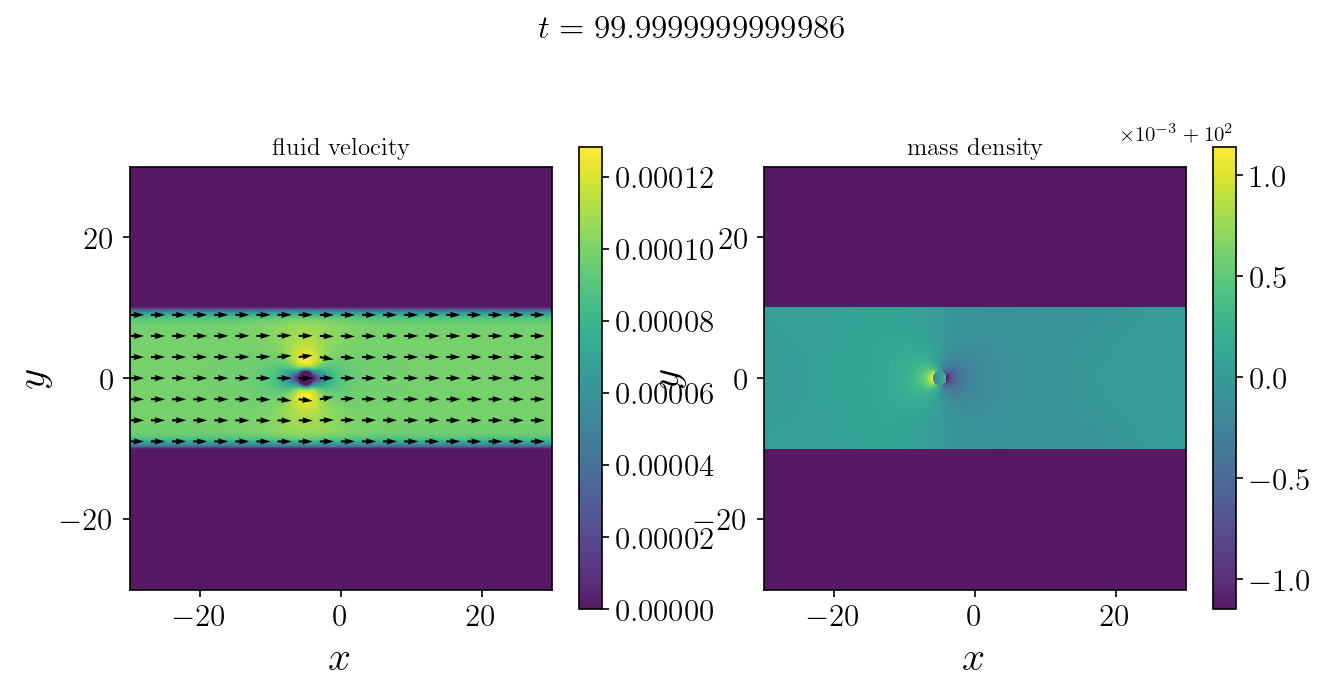

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Add a title for the whole figure
fig.suptitle(f"$t = {fluidDf.time.values[0]}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

maskStep = int(len(x_unique)/20)
# Create a mask for filtering
mask = (fluidDf['coordinate_x'].isin(x_unique[::maskStep])) & (fluidDf['coordinate_y'].isin(y_unique[::maskStep])) & (
    (fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2 > 1e-16)
)
# Filter the DataFrame
filtered_df = fluidDf[mask]

axes[0].quiver(
    filtered_df['coordinate_x'], 
    filtered_df['coordinate_y'], 
    (filtered_df.fluidVelocity_x / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    (filtered_df.fluidVelocity_y / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    scale = 30,
)

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
    vmin=min(fluidDf.query("massDensity > 0").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(len(axes)):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

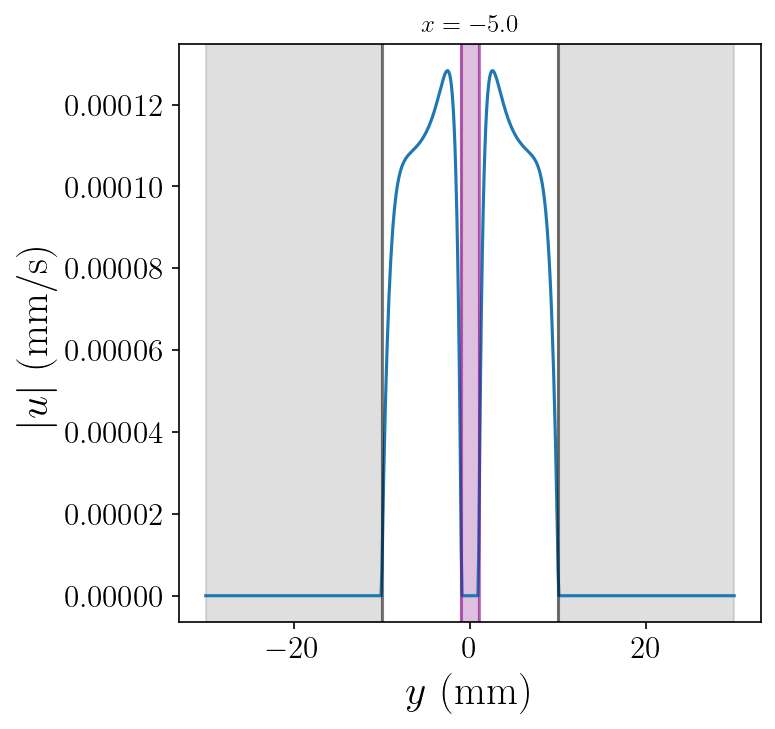

In [36]:
# v_x = fluidDf.query("coordinate_x == 15").filter(["coordinate_x","coordinate_y","fluidVelocity_x","fluidVelocity_y"])
v_x = fluidDf.query("coordinate_x == -5").filter(["coordinate_x","coordinate_y","fluidVelocity_x","fluidVelocity_y"])

fig, ax = plt.subplots(figsize = (5,5))

ax.plot(v_x.coordinate_y, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2)) 
ax.set_xlabel("$y$ (mm)")
ax.set_ylabel("$|u|$ (mm/s)")
ax.set_title(f"$x = {v_x.coordinate_x.values[0]}$")
ax.axvline(-10, color = "k", alpha = 0.5)
ax.axvline(10, color = "k", alpha = 0.5)
ax.axvspan(-30, -10, color='gray', alpha=0.25)  # Shade the wall
ax.axvspan(30, 10, color='gray', alpha=0.25)  # Shade the wall
ax.axvline(-1, color = "purple", alpha = 0.5)
ax.axvline(1, color = "purple", alpha = 0.5)
ax.axvspan(-1, 1, color='purple', alpha=0.25)  # Shade the wall
# ax.legend(loc='upper right')

plt.show()

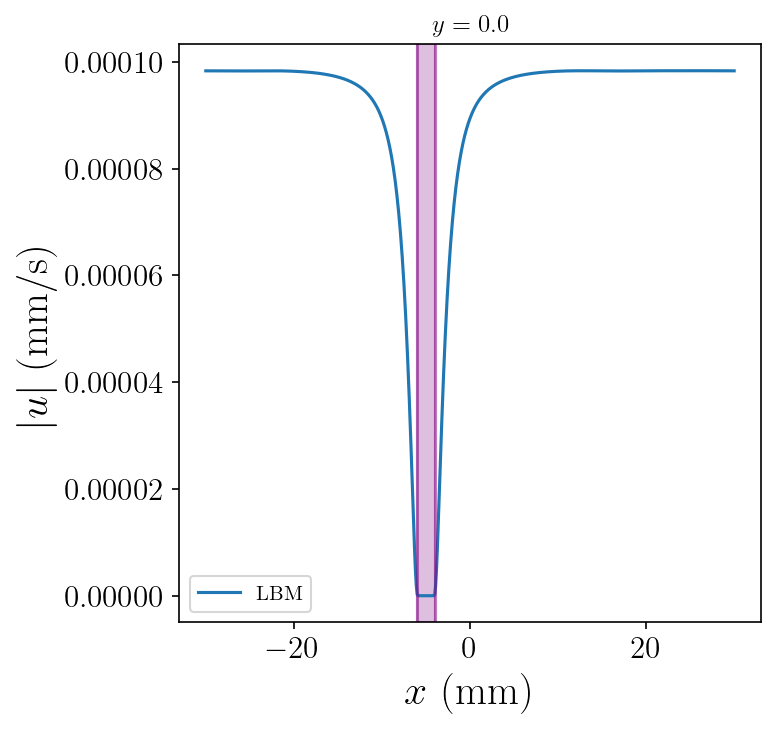

In [37]:
v_x = fluidDf.query("coordinate_y == 0").filter(["coordinate_x", "coordinate_y", "fluidVelocity_x", "fluidVelocity_y"])

fig, ax = plt.subplots(figsize = (5,5))

ax.plot(v_x.coordinate_x, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2), label='LBM') 
ax.set_xlabel("$x$ (mm)")
ax.set_ylabel("$|u|$ (mm/s)")
ax.set_title(f"$y = {v_x.coordinate_y.values[0]}$")
ax.axvline(-1-5, color = "purple", alpha = 0.5)
ax.axvline(1-5, color = "purple", alpha = 0.5)
ax.axvspan(-1-5, 1-5, color='purple', alpha=0.25)  # Shade the wall
# ax.legend(loc='upper right')
ax.legend()

plt.show()

In [38]:
def maxSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).max()

maximumFluidSpeed = [
    maxSpeed(pd.read_csv(dir + f"fluidTrj_{tick}.csv"))
for tick in ticks]
time = [pd.read_csv(dir + f"fluidTrj_{tick}.csv").time.values[0] for tick in ticks]

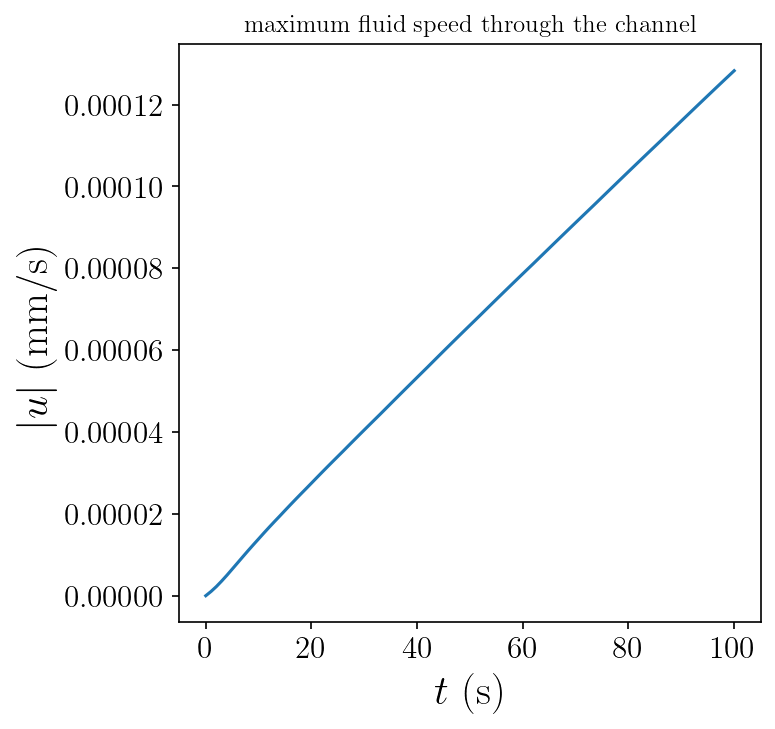

In [39]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, maximumFluidSpeed)
ax.set_title("maximum fluid speed through the channel")
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("$|u|$ (mm/s)")

plt.show()

# Tensor de estrés

In [40]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

tick   time  coordinate_x  coordinate_y  component_xx  \
id_x id_y                                                          
1    1     1000  100.0         -30.0         -30.0          -0.0   
     2     1000  100.0         -30.0         -29.9          -0.0   
     3     1000  100.0         -30.0         -29.8          -0.0   
     4     1000  100.0         -30.0         -29.7          -0.0   
     5     1000  100.0         -30.0         -29.6          -0.0   
...         ...    ...           ...           ...           ...   
601  597   1000  100.0          30.0          29.6          -0.0   
     598   1000  100.0          30.0          29.7          -0.0   
     599   1000  100.0          30.0          29.8          -0.0   
     600   1000  100.0          30.0          29.9          -0.0   
     601   1000  100.0          30.0          30.0          -0.0   

           component_yx  component_xy  component_yy  
id_x id_y                                            
1    1             -0.0          -0.0          -0.0  
     2             -0.0          -0.0          -0.0  
     3             -0.0          -0.0          -0.0  
     4             -0.0          -0.0          -0.0  
     5             -0.0          -0.0          -0.0  
...                 ...           ...           ...  
601  597           -0.0          -0.0          -0.0  
     598           -0.0          -0.0          -0.0  
     599           -0.0          -0.0          -0.0  
     600           -0.0          -0.0          -0.0  
     601           -0.0          -0.0          -0.0  

[361201 rows x 8 columns]

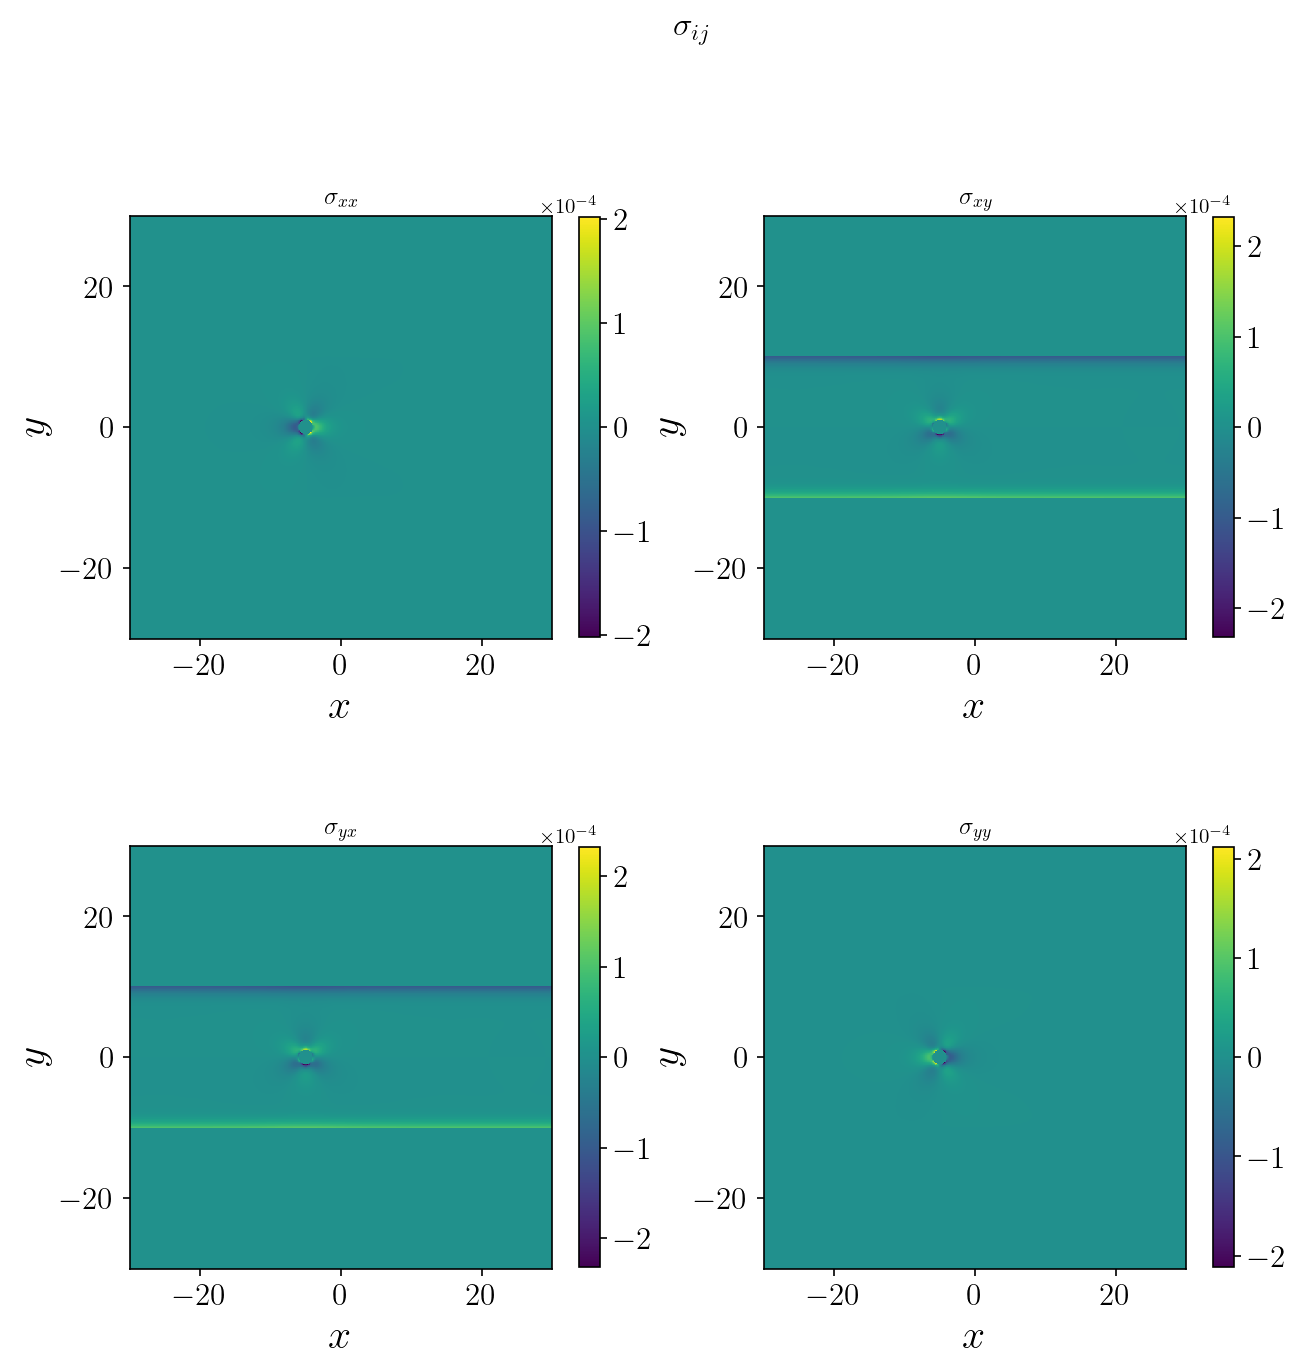

In [41]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()